In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep

hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [2]:
# This block is the same as 1_dataset.ipynb

dataset = "/eos/home-g/gkrzmanc/dataset_1408_CLIC_more_particles_DS.root"
#dataset = "/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root"

class Args:
    def __init__(self):
        self.data_train = [dataset]
        self.data_val = [dataset]
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [3]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)


=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [4]:
g, y = next(iterator)
y.shape
y

tensor([[ 3.9111e-02,  7.9521e-01, -6.0507e-01,  2.0657e+00,  2.0049e+00,
          4.9761e-01,  1.3000e+02],
        [-3.8235e-02, -2.7913e-01,  9.5949e-01,  5.1881e+00,  5.1881e+00,
          3.1618e-04, -2.2120e+03],
        [-3.6370e-01,  3.0957e-01,  8.7857e-01,  9.1639e-01,  7.6951e-01,
          4.9761e-01,  1.3000e+02],
        [-8.2833e-01,  4.9492e-01,  2.6253e-01,  1.1896e+00,  1.1814e+00,
          1.3957e-01,  2.1100e+02],
        [-8.1606e-01,  4.5764e-01,  3.5300e-01,  3.6735e+00,  3.6397e+00,
          4.9761e-01,  1.3000e+02],
        [ 1.3575e-01,  6.7313e-01,  7.2696e-01,  1.7070e+01,  1.7044e+01,
          9.3954e-01,  2.1120e+03],
        [-5.7269e-01,  5.3746e-01,  6.1900e-01,  3.6220e+01,  3.6220e+01,
          1.3951e-01,  2.1100e+02],
        [-4.7191e-01,  8.0765e-01, -3.5356e-01,  1.2217e+00,  1.1158e+00,
          4.9761e-01,  1.3000e+02],
        [-1.6586e-01,  9.1890e-01,  3.5792e-01,  1.9915e+01,  1.9893e+01,
          9.3958e-01,  2.1120e+03],
        [-

In [5]:
ht = g.ndata["hit_type"]
ht[ht[:, 2]==1]

tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])

In [6]:
#print(g.ndata["e_hits"].flatten())
#print(g.ndata["h"][:, 7])
hit_energies = g.ndata["e_hits"].flatten()
part_idx = g.ndata["particle_number"]
energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)[1:]
y_energy = y[:, 3]
#print(y_energy)

In [7]:
fracs1 = energy_from_showers/y_energy
print(fracs1)

tensor([0.1588, 0.9842, 0.6881, 0.0131, 0.0054, 0.1809, 0.5645, 0.7932, 0.3449,
        0.1094, 1.2266, 0.5017])


In [8]:
low_frac_particles = np.where(fracs1 < 0.05)[0] + 1
print(low_frac_particles)
low_frac_part_idx = []
for i in range(len(part_idx)):
    #print(part_idx[i])
    if part_idx[i].item() in low_frac_particles:
        low_frac_part_idx.append(i)
print(low_frac_part_idx)

[4 5]
[1687, 1688, 1689]


In [24]:
g.ndata["hit_type"].argmax(dim=1)

tensor([2, 2, 2,  ..., 3, 3, 3])

In [32]:
# Plot an event example - to show how highly granular the calorimeter is
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
xhits, yhits, zhits = g.ndata["h"][:, 0], g.ndata["h"][:, 1], g.ndata["h"][:, 2]
color = g.ndata["particle_number"]
color_hittype = g.ndata["hit_type"].argmax(dim=1)
color_ht1 = []
for i in color_hittype:
    if i == 2:
        color_ht1.append("red")
    else:
        color_ht1.append("blue") # HCAL
# plot a 3d scatter plot with plotly

import plotly.express as px
#fig = px.scatter_3d(x=xhits, y=yhits, z=zhits, color=color_hittype, marker=dict(size=10))
fig = go.Figure(data=[go.Scatter3d(
    x=xhits,
    y=yhits,
    z=zhits,
    mode='markers',
    marker=dict(
        size=3,
        color=color_ht1,
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.show()
fig.write_html("/eos/home-g/gkrzmanc/summ_results/3d_scatter_example_event.html")

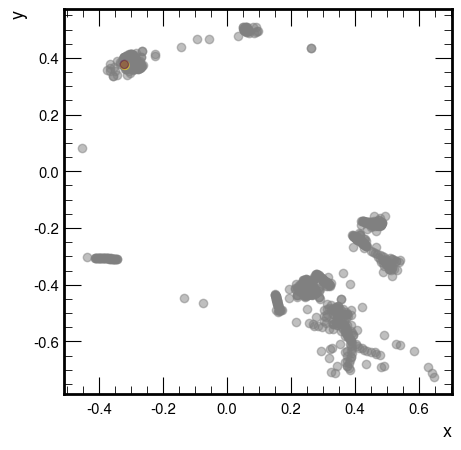

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(g.ndata["h"][:, 0], g.ndata["h"][:, 1], alpha=0.5, color="gray")
ax.scatter(g.ndata["h"][low_frac_part_idx, 0], g.ndata["h"][low_frac_part_idx, 1], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.scatter(g.ndata["theta_hits"], g.ndata["phi_hits"], alpha=0.5, color="gray")
#ax.scatter(g.ndata["theta_hits"][low_frac_part_idx], g.ndata["phi_hits"][low_frac_part_idx], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results/event_example_particle_FILTERED_low_energy_frac11.pdf")

In [31]:
g.ndata["h"][part_idx == 4]

tensor([[-0.1720,  0.0683,  0.6935,  0.0000,  0.0000,  1.0000,  0.0000,  0.0070,
          0.0000],
        [-0.1720,  0.0683,  0.6950,  0.0000,  0.0000,  1.0000,  0.0000,  0.0072,
          0.0000],
        [-0.1701,  0.0694,  0.6965,  0.0000,  0.0000,  1.0000,  0.0000,  0.0072,
          0.0000],
        [-0.1701,  0.0694,  0.6981,  0.0000,  0.0000,  1.0000,  0.0000,  0.0060,
          0.0000],
        [-0.1682,  0.0704,  0.6996,  0.0000,  0.0000,  1.0000,  0.0000,  0.0063,
          0.0000],
        [-0.1682,  0.0704,  0.7011,  0.0000,  0.0000,  1.0000,  0.0000,  0.0064,
          0.0000],
        [-0.1678,  0.0719,  0.7026,  0.0000,  0.0000,  1.0000,  0.0000,  0.0090,
          0.0000],
        [-0.1663,  0.0715,  0.7041,  0.0000,  0.0000,  1.0000,  0.0000,  0.0094,
          0.0000],
        [-0.1659,  0.0730,  0.7056,  0.0000,  0.0000,  1.0000,  0.0000,  0.0151,
          0.0000],
        [-0.1645,  0.0726,  0.7072,  0.0000,  0.0000,  1.0000,  0.0000,  0.0076,
          0.0000],


In [32]:
y_energy

tensor([ 1.5643, 15.7640, 14.4040,  0.8009,  1.4540,  0.6093, 10.5846,  6.6935,
         3.5072, 21.4915,  2.1166,  8.1898,  0.8961,  1.0997,  2.9000,  8.3875])

In [33]:
y_pid = y[:, -1].to(torch.long)
y_pid

tensor([2112,  211, -211,  211, 2212,  130,  130, 2112, 2212, 2112,  211, 2112,
         130,  211,  130, 2112])

In [10]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()#[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [11]:
all_ratios = {}
num_particles = []
part_energies = []
part_numb_of_hits = []

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(1000)):
    g, y = next(iterator)
    num_part = y.shape[0]
    num_particles.append(num_part)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)
    part_energies += y[:, 3].tolist()
    hits_per_part = scatter_sum(torch.ones_like(g.ndata["e_hits"].flatten()), g.ndata["particle_number"].long(), dim=0)[1:]
    part_numb_of_hits += hits_per_part.tolist()
    #TODOs tmrw: check particle number dist., how many are we throwing away



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:09<00:00,  2.71it/s]


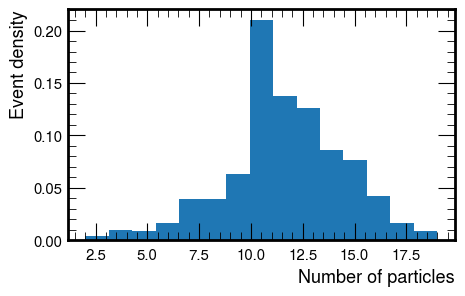

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of particles")
ax.hist(num_particles, bins=15, density=True)
ax.set_ylabel("Event density")
fig.show()


In [14]:
for key in all_ratios:
    print(key, len([x for x in all_ratios[key] if x <= 0.05])/len(all_ratios[key]))

-2212 0.1078811369509044
-211 0.12178148921363953
130 0.09697536638603056
2112 0.174496644295302
ALL 0.12363294600136705
2212 0.11621021465581051
211 0.10751879699248121


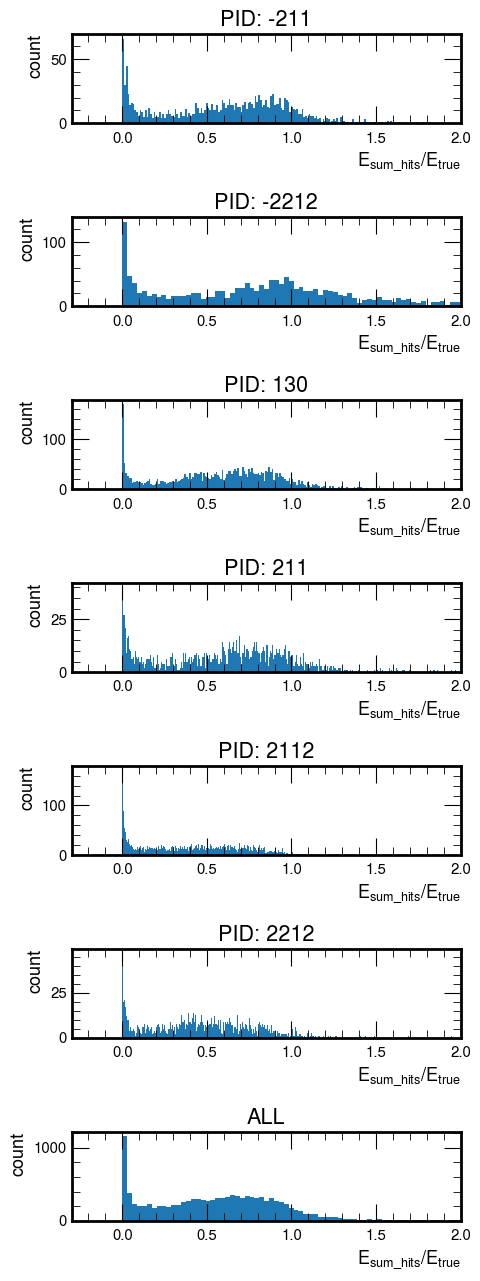

In [17]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 13))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    ax[i].set_xlim(-0.3, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum\_hits}/E_{true}$")
    #ax[i].set_title(f"{keys[i]} {len(all_ratios[keys[i]])} particles")
    if keys[i] == "ALL":
        ax[i].set_title("ALL")
    else:
        ax[i].set_title(f"PID: {keys[i]}")

fig.tight_layout()

#fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()

In [18]:
fig.savefig("/eos/home-g/gkrzmanc/summ_results/1000ev_15_20_part_ds_not_removed1.pdf")

In [79]:
# Energy vs number of hits plots...

import matplotlib as mpl
list(mpl.colormaps.keys())

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

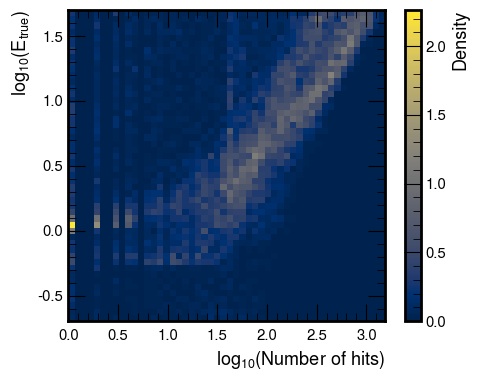

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.hist2d(np.log10(part_numb_of_hits), np.log10(part_energies), bins=50, density=True, cmap="cividis")
ax.set_xlabel("$log_{10} (Number\ of\ hits)$")
ax.set_ylabel("$log_{10} (E_{true})$")

# add colorbar
#im = ax.imshow(np.arange(100).reshape((10, 10)), cmap="viridis")
#cbar = fig.colorbar(im, ax=ax)
cbar = fig.colorbar(im[3], ax=ax)
cbar.set_label("Density")
#ax.yscale("log")
#ax.xscale("log")
fig.tight_layout()
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results/etrue_vs_nhits_100ev_unfiltered.pdf")